# Identify Artist from paintings
- Team: Bambu Paul, Creta Florin, Borodi Cristian, Mos Daniele

## Introduction

Computer analysis of visual art, especially paintings, is an interesting cross-disciplinary research domain.
With the spread of digitalization of art paintings,  research on diverse scientific approaches on painted images has become active.
The artistic style (or artistic movement) of a painting is a rich descriptor that captures both visual and historical information about the painting. 
Correctly identifying the artistic style of a paintings is crucial for indexing large artistic databases.
Our aim is to investigate the use of deep learning to solve the problem of detecting the artistic style of a painting.

## Dataset

- Dataset link [here](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
- We are using a dataset of paintings done by about 50 artists (found on Kaggle)
- The dataset contains three files:
  - Artists.csv: dataset of information for each artist
  - Images.zip: collection of images (full size), divided in folders and sequentially numbered
  - Resized.zip: same collection but images have been resized and extracted from folder structure
- The data was scraped from artchallenge.ru during the end of February 2019.

In [1]:
from google.colab import drive
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import imageio
import cv2
from keras.preprocessing import *
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *

In [45]:
# Mount the google drive to fetch the data 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [46]:
artists = pd.read_csv('/content/gdrive/MyDrive/Art-dataset/artists.csv')
artists.shape

(50, 8)

In [47]:
# When calcaulating weights we only want to keep track of artists that have many paintings (thsi case > 300)
artists_top = artists[['name', 'paintings']]
artists_top = artists[artists['paintings'] >= 250].reset_index()

In [48]:
# Show artists sorted by paintings number
artists = artists.sort_values(by=['paintings'], ascending=False)

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top.head(10)

,index,id,name,years,genre,nationality,bio,wikipedia,paintings,class_weight
0,8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877,0.462942
1,13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439,0.924829
2,15,15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336,1.208333
3,16,16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291,1.395189
4,19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328,1.237805
5,20,20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259,1.567568
6,30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702,0.578348
7,31,31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262,1.549618
8,32,32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255,1.592157
9,46,46,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311,1.305466


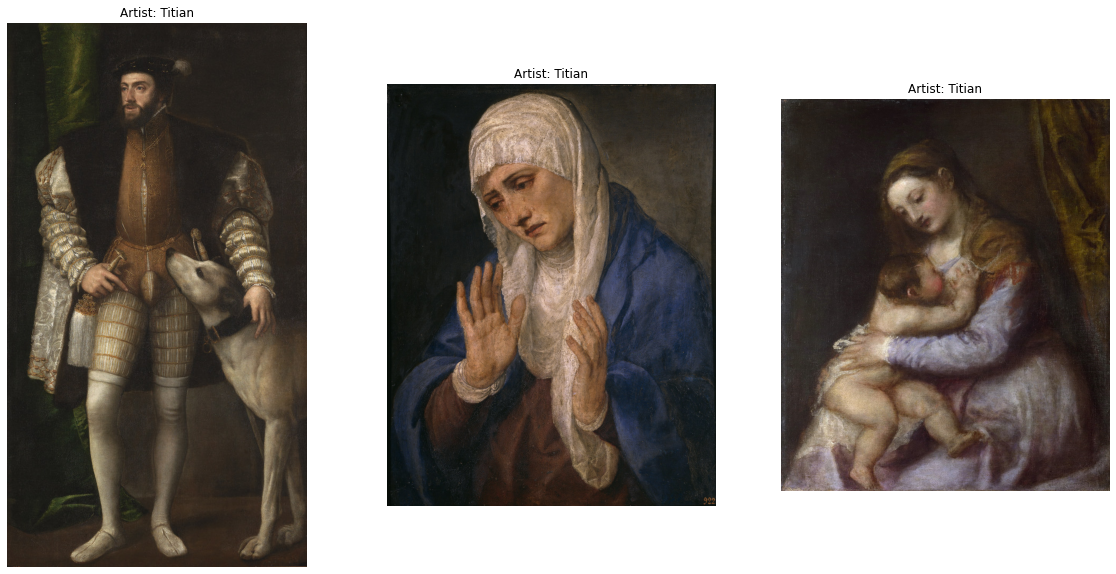

In [50]:
# See how paintings look like
fig, axes = plt.subplots(1, 3, figsize=(20,10))
images_dir = '/content/gdrive/MyDrive/Art-dataset/images/images'
artists_top_name = artists_top['name'].str.replace(' ', '_').values

for i in range(3):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

### Represent the data as a tf dataset
- adding data augmentation

In [51]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

In [52]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

In [53]:
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

Found 2989 images belonging to 10 classes.


In [54]:
valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

Found 743 images belonging to 10 classes.


## Model
- using pret-trained resnet50 model

In [55]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

Add extra layers to the base model

In [56]:
n_epoch = 10

In [57]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = keras.Model(inputs=base_model.input, outputs=output)

In [58]:
# Using Adam as an optimizer
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
# it will multiply the learning rate by 0.1
# whenever the best validation loss does not improve for five consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [62]:
class_weights = artists_top['class_weight'].to_dict()

history1 = model.fit_generator(generator=train_generator, steps_per_epoch=train_generator.n//batch_size,
                              validation_data=valid_generator, validation_steps=valid_generator.n//batch_size,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
186/186 [==============================] - 120s 582ms/step - loss: 1.4861 - accuracy: 0.4786 - val_loss: 2.6876 - val_accuracy: 0.0693 - lr: 1.0000e-04
Epoch 2/10
186/186 [==============================] - 107s 548ms/step - loss: 1.0998 - accuracy: 0.6949 - val_loss: 2.6875 - val_accuracy: 0.0693 - lr: 1.0000e-04
Epoch 3/10
186/186 [==============================] - 108s 549ms/step - loss: 0.9504 - accuracy: 0.7645 - val_loss: 2.4882 - val_accuracy: 0.0965 - lr: 1.0000e-04
Epoch 4/10
186/186 [==============================] - 107s 549ms/step - loss: 0.8386 - accuracy: 0.8133 - val_loss: 2.4038 - val_accuracy: 0.1997 - lr: 1.0000e-04
Epoch 5/10
186/186 [==============================] - 106s 543ms/step - loss: 0.7389 - accuracy: 0.8594 - val_loss: 2.1746 - val_accuracy: 0.2541 - lr: 1.0000e-04
Epoch 6/10
186/186 [==============================] - 106s 542ms/step - loss: 0.6375 - accuracy: 0.8971 - val_loss: 1.0558 - val_accuracy: 0.7215 - lr: 1.0000e-04
Epoch 7/10
186/186 [==

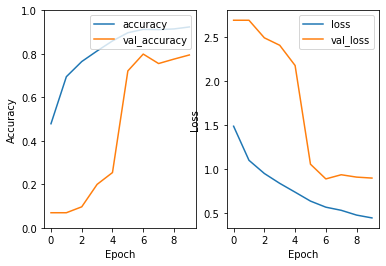

In [63]:
def plot_history(history):
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
plot_history(history1)

In [64]:
# Save model
model.save("./weights/final_train")

INFO:tensorflow:Assets written to: ./weights/final_train/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Test on random images

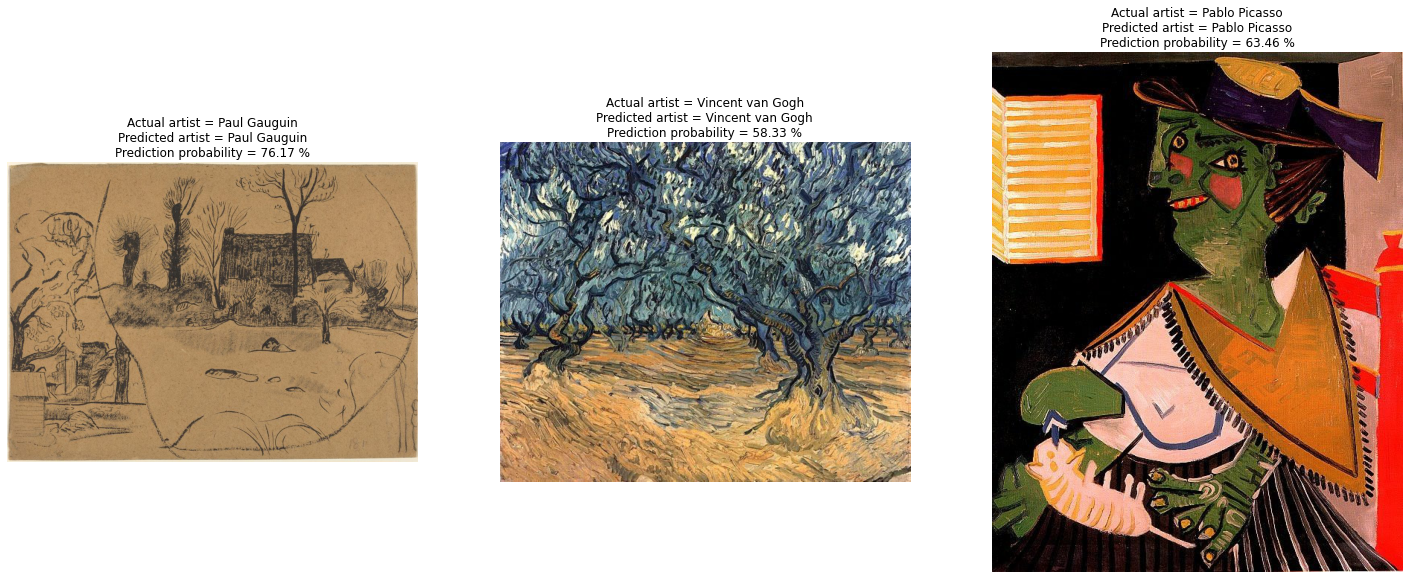

In [69]:
from keras.preprocessing import *
# number of images
n = 3
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image
    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))
    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

In [66]:
# Download weights
from google.colab import files
files.download("./weights/final_train")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing on paintings

In [72]:
# upload image
import os
from google.colab import files
import shutil

upload_folder = 'upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving download.jpg to download.jpg
move download.jpg to upload/download.jpg


Predicted artist = Pablo Picasso
Prediction probability = 64.47181701660156 %


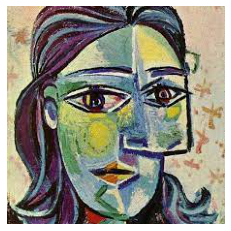

In [73]:
test_image_url = '/content/upload/download.jpg'

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

web_image = imageio.imread(test_image_url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = keras.preprocessing.image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(test_image_url))
plt.axis('off')
plt.show()